<a href="https://colab.research.google.com/github/seungwoo-Jang/modu_quest/blob/main/EXPLORATION_RS4/E04/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

문장길이 평균 :  15.971019612059036
문장길이 최대 :  116
문장길이 표준편차 :  12.844062009473816
pad_sequences maxlen :  41
전체 문장의 0.9342629991962691%가 maxlen 설정값 이내에 포함됩니다. 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 lstm (LSTM)                 (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 162,401
Trainable params: 162,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
286/286 [=======

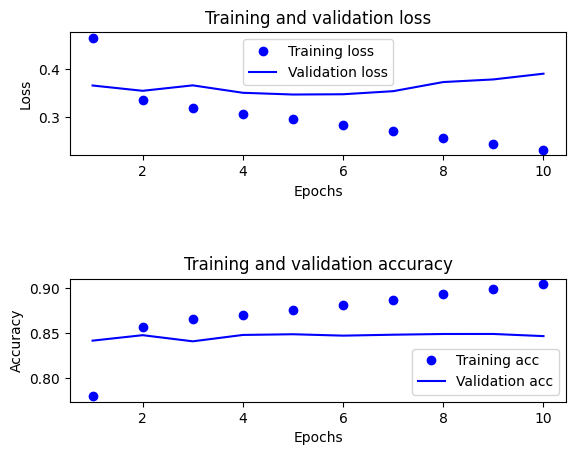

(10000, 16)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 41, 100)           1000000   
                                                                 
 conv1d (Conv1D)             (None, 35, 16)            11216     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 16)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 16)             1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)    

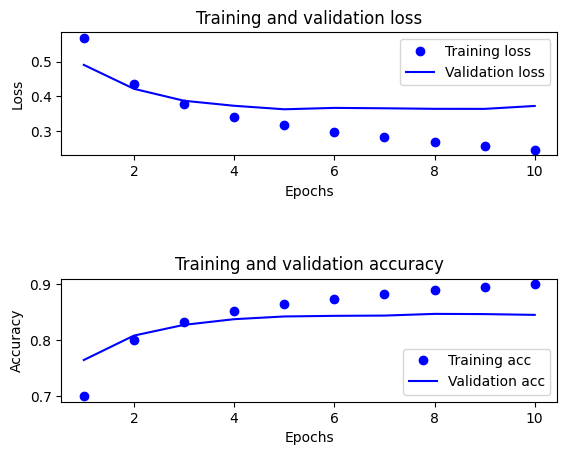

In [2]:
#코랩에서 Mecab 사용하기 위해 설치
# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
# !bash Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh

import pandas
import konlpy
import gensim
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import tensorflow as tf
import matplotlib.pyplot as plt
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

# 데이터를 읽어봅시다. 
train_data = pd.read_table('/content/drive/MyDrive/Colab Notebooks/EXPLORATION_data/E04/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Colab Notebooks/EXPLORATION_data/E04/ratings_test.txt')

#/lib/mecab
tokenizer = Mecab()

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')  
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how='any')  

    x_train = []
    for sentence in train_data['document']:
      temp_X = tokenizer.morphs(sentence) #한국어 문장을 형태소 단위로 분리
      temp_X = [word for word in temp_X if not word in stopwords]
      x_train.append(temp_X)

    x_test = []
    for sentence in test_data['document']:
      temp_X = tokenizer.morphs(sentence)
      temp_X = [word for word in temp_X if not word in stopwords]
      x_test.append(temp_X)

    words = np.concatenate(x_train).tolist()
    counter = Counter(words) #words 리스트에 있는 단어들의 빈도를 계산
    counter = counter.most_common(num_words-4) #가장 빈도가 높은 상위 10000-4개의 단어와 그 빈도수를 추출합니다. 
                                           #-4를 하는 이유는 이후에 예약된 4개의 단어를 추가하기 위해서
    vocab = ['','','',''] + [key for key,_ in counter] #이후에 예약된 4개의 단어를 추가하기 위한 용도로 사용
    word_to_index = {word:index for index,word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
      return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

    x_train = list(map(wordlist_to_indexlist, x_train))  
    x_test = list(map(wordlist_to_indexlist, x_test))  

    return x_train,np.array(list(train_data['label'])), x_test,np.array(list(test_data['label'])),word_to_index

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre', 
                                                       maxlen=maxlen)


#RNN
vocab_size = 10000    # 어휘 사전의 크기입니다
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 16로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_test, y_test),
                    verbose=1)

results = model.evaluate(x_test, y_test, verbose=2)
print(results)

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
fig, (ax1,ax2) = plt.subplots(2)
fig.subplots_adjust(hspace=1)
ax1.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, acc, 'bo', label='Training acc')
ax2.plot(epochs, val_acc, 'b', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

#Word2Vec의 적용
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)  

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/content/drive/MyDrive/Colab Notebooks/EXPLORATION_data/E04/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['끝']
word_vectors.similar_by_word("끝")

#학습되어있는 Embedding 파라미터
word2vec_path = '/content/drive/MyDrive/Colab Notebooks/EXPLORATION_data/E04/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_path)
vector = word2vec.wv

# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
vector.most_similar("끝")

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = vector["끝"].shape[0]  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in vector:
        embedding_matrix[i] = vector[index_to_word[i]]

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()        

# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_test, y_test),
                    verbose=1)

# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
fig, (ax1,ax2) = plt.subplots(2)
fig.subplots_adjust(hspace=1)
ax1.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, acc, 'bo', label='Training acc')
ax2.plot(epochs, val_acc, 'b', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()